In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!pip install transformers

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
%matplotlib inline
sns.set(color_codes=True)
from transformers import BertTokenizer,BertForSequenceClassification,AdamW

In [4]:
!unzip drive/MyDrive/trainingandtestdata.zip

Archive:  drive/MyDrive/trainingandtestdata.zip
replace testdata.manual.2009.06.14.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [3]:
testData = pd.read_csv('testdata.manual.2009.06.14.csv')
trainData = pd.read_csv('training.1600000.processed.noemoticon.csv' ,  encoding='latin-1')

In [4]:
columnNames = ['polarity' , 'id' , 'date' , 'query' , 'user', 'text']
trainData.columns = columnNames
testData.columns = columnNames

In [5]:
testData = testData.loc[testData["polarity"] != 2]

In [6]:
testData.loc[testData['polarity'] == 4, 'polarity'] = 1

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [7]:
trainData.loc[trainData['polarity'] == 4, 'polarity'] = 1

In [8]:
# columnNames = ['polarity' , 'id' , 'date' , 'query' , 'user', 'text']
del testData['id']
del testData['date']
del testData['query']
del testData['user']
del trainData ['id']
del trainData['date']
del trainData['query']
del trainData['user']

In [9]:
testData.shape  , trainData.shape

((358, 2), (1599999, 2))

In [10]:
trainData.head()

,polarity,text
0,0,is upset that he can't update his Facebook by ...
1,0,@Kenichan I dived many times for the ball. Man...
2,0,my whole body feels itchy and like its on fire
3,0,"@nationwideclass no, it's not behaving at all...."
4,0,@Kwesidei not the whole crew


In [11]:
 trainData = trainData.reindex(np.random.permutation(trainData.index))

In [12]:
trainData.head()

,polarity,text
426147,0,@sweetoblivion26 That sounds pretty awful I'm...
638984,0,@OfficerAnni you're so confused that the unthi...
984520,1,@Noway57 Haha...I'm a fan since I was in prima...
1326164,1,http://tinyurl.com/m3pksa Microsoft 'Natal' - ...
1549611,1,@gizelleramos oh it sounded like you had summe...


In [13]:
testData.head()

,polarity,text
0,1,Reading my kindle2... Love it... Lee childs i...
1,1,"Ok, first assesment of the #kindle2 ...it fuck..."
2,1,@kenburbary You'll love your Kindle2. I've had...
3,1,@mikefish Fair enough. But i have the Kindle2...
4,1,@richardebaker no. it is too big. I'm quite ha...


In [14]:
 testData = testData.reindex(np.random.permutation(testData.index))

In [15]:
testData.head()

,polarity,text
455,1,I love my Kindle2. No more stacks of books to ...
377,0,Having the old Coca-Cola guy on the GM board i...
98,0,"It's a bank holiday, yet I'm only out of work ..."
326,1,Will the Lakers kick the Nuggets ass tonight?
221,0,Just blocked United Blood Services using Googl...


In [16]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

## Defining set containing all stopwords in english.
stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

In [17]:
import re
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

def preprocess(textdata):
    processedText = []
    
    # Create Lemmatizer and Stemmer.
    # wordLemm = WordNetLemmatizer()
    
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    # for tweet in textdata:
    tweet =textdata
    # print(tweet)
    tweet = tweet.lower()
    
    # Replace all URls with 'URL'
    tweet = re.sub(urlPattern,' URL',tweet)
    # Replace all emojis.
    for emoji in emojis.keys():
        tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])        
    # Replace @USERNAME to 'USER'.
    tweet = re.sub(userPattern,' USER', tweet)        
    # Replace all non alphabets.
    tweet = re.sub(alphaPattern, " ", tweet)
    # Replace 3 or more consecutive letters by 2 letter.
    tweet = re.sub(sequencePattern, seqReplacePattern, tweet)

    tweetwords = ''
    for word in tweet.split():
        # Checking if the word is a stopword.
        #if word not in stopwordlist:
        if len(word)>1:
            # Lemmatizing the word.
            # word = wordLemm.lemmatize(word)
            tweetwords += (word+' ')
        
    processedText.append(tweetwords)
        
    return processedText[0]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [18]:
trainData['text'] = trainData.text.apply(preprocess)

In [19]:
testData['text'] = testData.text.apply(preprocess)

In [20]:
trainData.head()

,polarity,text
426147,0,USER that sounds pretty awful so sorry haven g...
638984,0,USER you re so confused that the unthinkable h...
984520,1,USER haha fan since was in primary school haha...
1326164,1,URL microsoft natal will this actually work wi...
1549611,1,USER oh it sounded like you had summer school ...


In [21]:
testData.head()

,polarity,text
455,1,love my kindle2 no more stacks of books to tri...
377,0,having the old coca cola guy on the gm board i...
98,0,it bank holiday yet only out of work now exam ...
326,1,will the lakers kick the nuggets ass tonight
221,0,just blocked united blood services using googl...


In [22]:
train_labels = trainData.polarity.values
train_text = trainData.text.values

In [23]:
test_labels = testData.polarity.values
test_text = testData.text.values

In [24]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased',do_lower_case = True)

In [25]:
input_ids_ = []
attention_mask_ = []
for i in train_text:
    encoded_data = tokenizer.encode_plus( i, add_special_tokens=True, max_length=64, pad_to_max_length = True, return_attention_mask= True,
    return_tensors='pt')
    input_ids_.append(encoded_data['input_ids'])
    attention_mask_.append(encoded_data['attention_mask'])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [26]:
input_ids = torch.cat(input_ids_,dim=0)
attention_mask = torch.cat(attention_mask_,dim=0)
train_labels = torch.tensor(train_labels)

In [27]:
from torch.utils.data import DataLoader,SequentialSampler,RandomSampler,TensorDataset,random_split

In [28]:
num = 100000
dataset = TensorDataset(input_ids[:num],attention_mask[:num],train_labels[:num])
train_size = int(0.8*len(dataset))
val_size = len(dataset) - train_size

train_dataset,val_dataset = random_split(dataset,[train_size,val_size])

print('Training Size - ',train_size)
print('Validation Size - ',val_size)

Training Size -  80000
Validation Size -  20000


In [29]:
train_dl = DataLoader(train_dataset,sampler = RandomSampler(train_dataset),
                     batch_size = 64)
val_dl = DataLoader(val_dataset,sampler = SequentialSampler(val_dataset),
                     batch_size = 64)

In [30]:
len(train_dl),len(val_dl)

(1250, 313)

In [31]:
model = BertForSequenceClassification.from_pretrained( 'bert-base-uncased', num_labels = 2, output_attentions = False, output_hidden_states = False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [32]:
import random

seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

cuda


In [34]:
optimizer = AdamW(model.parameters(),lr = 2e-5,eps=1e-8)

In [35]:
from transformers import get_linear_schedule_with_warmup
epochs = 4
total_steps = len(train_dl)*epochs
scheduler = get_linear_schedule_with_warmup(optimizer,num_warmup_steps=0,
                                           num_training_steps=total_steps)

In [36]:
def accuracy(preds,labels):
    pred_flat = np.argmax(preds,axis=1).flatten()
    label_flat = labels.flatten()
    return np.sum(pred_flat==label_flat)/len(label_flat)

In [37]:
def evaluate(dataloader_test):
    model.eval()
    loss_val_total = 0
    predictions,true_vals = [],[]
    for batch in dataloader_test:
        batch = tuple(b.to(device) for b in batch)
        inputs = {
            'input_ids':batch[0],
            'attention_mask': batch[1],
            'labels': batch[2]
        }
        with torch.no_grad():
            outputs = model(**inputs)
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()
        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    loss_val_avg = loss_val_total / len(dataloader_test)
    predictions = np.concatenate(predictions,axis=0)
    true_vals = np.concatenate(true_vals,axis=0)
    return loss_val_avg,predictions,true_vals

In [40]:
losses = []
validation_losses = []
accuracies = []
from tqdm.notebook import tqdm
torch.cuda.empty_cache()
for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0

    progress_bar = tqdm(train_dl, desc='Epoch {:1d}'.format(epoch), leave=False, disable=False)
    for batch in progress_bar:

        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }       

        outputs = model(**inputs)
        loss = outputs[0]
        


        loss_train_total += loss.item()
        losses.append(loss.item())
        loss.backward()

        

        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()
        # train_loss, predictions_train, true_train = evaluate(train_dl)
        # train_accuracy = accuracy (predictions_train  , true_train)

        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
         
        
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(train_dl)            
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(val_dl)
    validation_losses.append(val_loss)
    val_acc = accuracy(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'Accuracy: {val_acc}')

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1250 [00:00<?, ?it/s]


Epoch 1
Training loss: 0.3222084024488926
Validation loss: 0.37262657560860385
Accuracy: 0.841


Epoch 2:   0%|          | 0/1250 [00:00<?, ?it/s]


Epoch 2
Training loss: 0.24739518510103226
Validation loss: 0.39520904750298386
Accuracy: 0.8402


Epoch 3:   0%|          | 0/1250 [00:00<?, ?it/s]


Epoch 3
Training loss: 0.19287507625222206
Validation loss: 0.4553220868110657
Accuracy: 0.83785


Epoch 4:   0%|          | 0/1250 [00:00<?, ?it/s]


Epoch 4
Training loss: 0.1738841490983963
Validation loss: 0.4553220868110657
Accuracy: 0.83785


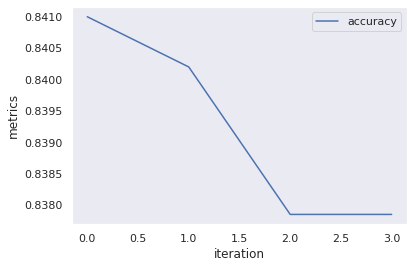

In [45]:

import matplotlib.pyplot as plt
accs = [0.841 , 0.8402 ,  0.83785 , 0.83785]
plt.plot(accs)
plt.ylabel('metrics')
plt.xlabel('iteration')
plt.legend(['accuracy'])
plt.grid()

plt.show()

In [ ]:
import matplotlib.pyplot as plt
plt.plot(validation_losses)
plt.ylabel('metrics')
plt.xlabel('iteration')
plt.legend(['validation loss'])
plt.grid()

plt.show()

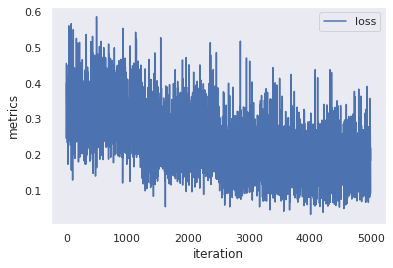

In [43]:
import matplotlib.pyplot as plt
plt.plot(losses)
plt.ylabel('metrics')
plt.xlabel('iteration')
plt.legend(['loss'])
plt.grid()

plt.show()

In [46]:
output_dir = './'
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

('./tokenizer_config.json',
 './special_tokens_map.json',
 './vocab.txt',
 './added_tokens.json')

In [47]:
from transformers import BertTokenizer,BertForSequenceClassification
import torch
print('Loading BERT tokenizer...')
output_dir = './'
tokenizer = BertTokenizer.from_pretrained(output_dir)
model_loaded = BertForSequenceClassification.from_pretrained(output_dir)

Loading BERT tokenizer...


In [48]:
def predictSentiment(sent):
    output_dir = './'
    tokenizer = BertTokenizer.from_pretrained(output_dir)
    model_loaded = BertForSequenceClassification.from_pretrained(output_dir)
    encoded_dict = tokenizer.encode_plus( sent, add_special_tokens = True, max_length = 64, pad_to_max_length = True,
                        return_attention_mask = True, return_tensors = 'pt', )
        
    input_id = encoded_dict['input_ids']

    attention_mask = encoded_dict['attention_mask']
    input_id = torch.LongTensor(input_id)
    attention_mask = torch.LongTensor(attention_mask)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model_loaded = model_loaded.to(device)
    input_id = input_id.to(device)
    attention_mask = attention_mask.to(device)

    with torch.no_grad():
        outputs = model_loaded(input_id, token_type_ids=None, attention_mask=attention_mask)

    logits = outputs[0]
    index = logits.argmax()
    return index

In [49]:
ans = predictSentiment('she seems really happy')
if ans == 1:
    print("Positive")
else:
    print("Negative")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Positive


In [50]:
ans = predictSentiment('he hates everyone')
if ans == 1:
    print("Positive")
else:
    print("Negative")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Negative


In [51]:
pred = predictSentiment('it was a wonderful event')
if pred == 1:
    print("Positive")
else:
    print("Negative")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


Positive


In [52]:
predictions = []
for row in testData.iterrows():
  selected_sentence = row[1]['text']
  pred = predictSentiment(selected_sentence)
  predictions.append(pred.item())

  if pred == 1 :
    result = 'positive'
  else:
    result = 'negative'
  if  row[1]['polarity'] == 1:
    polarity = 'positive'
  else: 
    polarity = 'negative'
  
  print("selected sentence: " , selected_sentence)
  print("actual label=  " , polarity)
  print("predicted label= " , result)
  print("********************************************************************")

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:2232: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


selected sentence:  love my kindle2 no more stacks of books to trip over on the way to the loo 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  having the old coca cola guy on the gm board is stupid has heck tcot ala 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  it bank holiday yet only out of work now exam season sucksEMOJIsad 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  will the lakers kick the nuggets ass tonight 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  just blocked united blood services using google voice they call more than those car warranty guys 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  back when worked for nike we had one fav word just do it EMOJIsmile 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  itchy back dont ya hate it 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  hello twitter api EMOJIwink 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  good news just had call from the visa office saying everything is fine what relief am sick of scams out there stealing 
actual label=   positive
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  wth have never seen line this loong at time warner before ugh 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  can wait for the great american food and music festival at shoreline tomorrow mm katz pastrami and bobby flay yes please 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  it is shame about gm what if they are forced to make only cars the white house thinks will sell what do you think 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  whoever is running time warner needs to be repeatedly raped by rhino so they understand the consequences of putting out shitty cable svcs 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER wtf is the point of deleting tweets if they can still be found in summize and searches twitter please fix that thanks and bye 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  omg the commercials alone on espn are going to drive me nuts 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  can wait going to see star trek tonight 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  wat the heck is north korea doing they just conducted powerful nuclear tests follow the link URL 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  according to the create school notre dame will have receivers in ncaa 10 at 84 or higher rating EMOJIsmile sweet 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  boarding plane for san francisco in hour hr flight blech 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  just changed my default pic to nike basketball cause bball is awesome 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  soo dissapointed they sent danny gokey home you still rock danny my hometown hero yeah milrockee 
actual label=   positive
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  is being fucked by time warner cable didnt know modems could explode and susan boyle sucks too 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  time warner has the worse customer service ever will never use them again 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  rt USER awesome jquery reference book for coda URL webdesign 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  is lovin his nike already and that only from running on the spot in his bedroom 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  reading on my new kindle2 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  rt USER five things wolfram alpha does better and vastly different than google URL 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  just realized we three monkeys in the white obama biden pelosi sarah palin 2012 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  give man fish feed him for the day teach him to fish feed him for life buy him gm and him over for good 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  my wrist still hurts have to get it looked at hate the dr dentist scary places EMOJIsad time to watch eagle eye if you want to join txt 
actual label=   positive
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  saw night at the museum last night pretty crazy movie but the cast was awesome so it was well worth it robin williams forever 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  monday already iran may implode kitchen is disaster USER seems happy USER had nice weekend and USER is great whoop 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER ooh what model are you getting have the 40d and love love love love it 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  my dentist appt today was actually quite enjoyable 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  you guys see this why does time warner have to suck so much ass really wish could get verse at my apartment URL 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  just got barraged by horde of insects hungry for my kitchen light so scary 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  as may have noticed not too happy about the gm situation nor aig lehman et al 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  gonna go see bobby flay 2moro at shoreline eat and drink gonna be good 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER oh those are awesome so wish they weren owned by nike EMOJIsad 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  could time warner cable suck more no 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER right lol we ll get there have high expectations warren buffet style 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  obama got jokes haha just got to watch bit of his after dinner speech from last night in love with mr president EMOJIwink 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER no lebron is the best 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  still love my kindle2 but reading the new york times on it does not feel natural miss the bloomingdale ads 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  goodby silverstein agency new site URL great 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  itchy and miserable 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  we went to stanford university today got tour made me want to go back to college it also decided all of our kids will go there 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  no watching the night at the museum getting really good 
actual label=   positive
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER we tried but time warner wasn being nice so we recorded today EMOJIsmile 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  fuck this economy hate aig and their non loan given asses 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  am furious with time warner and their phone promotions 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER umm having some time warner problems 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  can watch tv without tivo and after all these years the time warner dvr still sucks URL 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER current use the nikon d90 and love it but not as much as the canon 40d 50d chose the d90 for the video feature my mistake 
actual label=   positive
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER dood got free google android phone at the conference the g2 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  ok first assesment of the kindle2 it fucking rocks 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER hate going to the dentist 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  north korea please cease this douchebaggery china doesn even like you anymore URL 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER lebron is hometown hero to me lol love the lakers but let go cavs lol 
actual label=   positive
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  hate time warner soo wish had vios cant watch the fricken mets game buffering feel like im watching free internet porn 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  comcast sucks 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  omgg ohhdee want mcdonalds damn wonder if its open lol 
actual label=   positive
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  super investors great weekend read here from warren buffet oldie but goodie URL 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  the real aig scandal URL 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  just got mcdonalds goddam those eggs make me sick yeah laker up date go lakers not much of an update well it true so suck it 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  star trek was as good as everyone said 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  obama speech was pretty awesome last night URL 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER oh yes but if gm dies it will only be worth more boo hahaha 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  is it me or is this the best the playoffs have been in years oh yea lebron and melo in the finals 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  colin powell rocked yesterday on cbs cheney needs to shut the hell up and go home powell is man of honor and served our country proudly 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  goodby silverstein new site URL enjoy it 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  new nike muppet commercials are pretty cute why do we live together again 
actual label=   positive
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  obama is quite good comedian check out his dinner speech on cnn EMOJIsmile very funny jokes 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  getting ready to test out some burger receipes this weekend bobby flay has some great receipes to try thanks bobby 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  wolfram alpha sucks even for researchers the information provided is less than you can get from google or wikipedia totally useless 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  can we just go ahead and blow north korea off the map already 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  started to think that citi is in really deep amp are they gonna survive the turmoil or are they gonna be the next aig 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  just got my new toy canon 50d love love love it 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  arg twitter api is making me crazy 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  stopped to have lunch at mcdonalds chicken nuggetss EMOJIsmile yummy 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  played with an android google phone the slide out screen scares me would break that fucker so fast still prefer my iphone 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER it definitely under warranty amp my experience is the amazon support for kindle is great had to contact them about my kindle2 
actual label=   positive
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  was talking to this guy last night and he was telling me that he is die hard spurs fan he also told me that he hates lebron james 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER lebron is the boss 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  wow everyone at the google conference got free g2 with month of unlimited service 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  is upset about the whole gm thing life as know it is so screwed up 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER its not so much my obsession with cell phones but the iphone slave to at amp forever because of it EMOJIsmile 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  loving my new kindle2 named her kendra in case were wondering the cookbook is the tool cuz it tells all the tricks best gift evr 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER gm good riddance sad though 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  ooh north korea is in troublee URL 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  will never buy government motors vehicle until just recently drove gm cars since 1988 when bought URL 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  higher physics exam tommorow not lookin forward to it much EMOJIsad 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  it unfortunate that after the stimulus plan was put in place twice to help gm on the back of the american people has led to the inevitable 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  talk is cheap bing that ll stick with google URL 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  have google addiction thank you for pointing that out USER hahaha 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  nike rocks super grateful for what ve done with them EMOJIsmile amp the european division of nike is beyond USER USER 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER have the kindle2 ve seen pictures of the dx but haven seen it in person love my kindle on it everyday 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  took the graduate field exam for computer science today nothing makes you feel like more of an idiot than lambda calculus 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  class the 50d is supposed to come today EMOJIsmile 
actual label=   positive
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  naive bayes using em for text classification really frustrating 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  up big or go home aig 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  at amp is complete fail 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  say some sports writers are idiots for saying roger federer is one of the best ever in tennis roger federer is the best ever in tennis 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  loved night at the museum 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  say we just cut out the small talk at amp new slogan you give us your money apologies to bob geldof 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER my dentist is great but she expensive 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  nancy pelosi gave the worst commencement speech ve ever heard yes still bitter about this 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  pissed at time warner for causin me to have slow internet problems 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  lyx is cool 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  watching night at the museum lmao 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER URL yay happy place place place love google 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  moving to east palo alto 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  by the way totally inspired by this freaky nike commercial URL 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  obama administration must stop bonuses to aig ponzi schemers URL 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  judd apatow creates fake sitcom on nbc com to market his new movie viral marketing at its best URL 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  just bought my tickets for the 2010 fifa world cup in south africa its going to be great summer URL 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER what is at amp fucking up 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  jquery is my new best friend 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER the g2 is amazing btw huge improvement over the g1 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  glad didnt do bay to breakers today it 100 freaking degrees in san francisco wtf 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  ahh got rid of stupid time warner today amp now taking nap while the roomies cook for me pretty good end for monday EMOJIsmile 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  rt USER URL great article by malcolm gladwell 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  just watched night at the museum so stinkin cute 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER when lebron is done in the nba he will probably be greater than kobe like said kobe is good but there alot of good players 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  impatiently awaiting the arrival of the time warner guy it way too pretty to be inside all afternoon 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  curses the twitter api limit 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER hey no offense but malcolm gladwell is pretenious annoying cunt and he brings you down cant read his shit 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  obviously not siding with cheney here URL 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER USER just got us 50d for the office 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  malcolm gladwell might be my new man crush 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  awesome viral marketing for funny people URL 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  URL good video from google on using search options 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  off to the nike factory 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  trouble in iran see hmm iran iran so far away flockofseagullsweregeopoliticallycorrect 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  saw night at the museum out of sheer desperation who is funding these movies 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  googleio o3d bringing 3d graphics to the browser very nice tbh funfun 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER finally got around to using jquery to make my bio collapse yay for slide animations 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  after using latex lot any other typeset mathematics just looks hideous 
actual label=   positive
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER fair enough but have the kindle2 and think it perfect EMOJIsmile 
actual label=   positive
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  cant sleep my tooth is aching 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  rt USER goodby silverstein new site URL enjoy it nice find 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  srsly hate the stupid twitter api timeout thing soo annoying EMOJIsad 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  so night at the museum was awesome much better than part next weekend we ll see up 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  atebits just finished watching your stanford iphone class session really appreciate it you rock 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  shout outs to all east palo alto for being in the buildin karizmakaze 50cal gta also thanks to profits of doom universal hempz cracka 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  viral marketing fail this acia pills brand oughta get shut down for hacking into people messenger get msgs in day arrgh 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  omg so bored amp my tattoos are so itchy help aha 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  needs someone to explain lambda calculus to him EMOJIsad 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  excited about seeing bobby flay and guy fieri tomorrow at the great american food amp music fest 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  work til 6pm lets go lakers 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  reading bill clinton fail obama win URL 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  safeway place is nightmare right now bumming 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER URL awesome seeing the show friday at the shoreline amphitheatre never seen nin before can wait 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER yay glad you got the phone still damn you at amp 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  dick cheney dishonest speech about torture terror and obama fred kaplan slate URL 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER hi just saw your stanford talk and really liked your advice just saying hi from singapore yes the videos do get around 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  night at the museum wolverine and junk food perfect monday 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  watching lebron highlights damn that niggas good 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  reading michael palin book the python years great book also recommend warren buffet amp nelson mandela bio 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  fuck no internet damn time warner 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER have you tried nike addictive 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  insects have infected my spinach plant EMOJIsad 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER lebron is beast but still cheering the til the end 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  ugh the amount of times these stupid insects have bitten me grr 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  URL awesome come back from USER via USER 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  highly recommend URL by malcolm gladwell 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  time warner cable phone reps dumber than nails ugh cable was working 10 mins ago now its not wtf 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  have to go to booz allen hamilton for 2hr meeting EMOJIsad but then get to go home EMOJIsmile 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  safeway is very rock roll tonight 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  the ever amazing psyop and goodby silverstein amp partners for hp URL have to go play with after effects now 
actual label=   positive
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  back from seeing star trek and night at the museum star trek was amazing but night at the museum was eh 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  ok so lots of buzz from io2009 but how lucky are they free g2 URL 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  seriously underestimated malcolm gladwell want to meet this dude 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  lakers tonight let go 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  ahh back in real text editing environment lt latex 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  rt USER rt great USER someone sitting in the shade today because someone planted tree long time ago warren buffet 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  using linux and loving it so much nicer than windows looking forward to using the wysiwyg latex editor 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  going to the dentist later 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  stanford university facebook profile is one of the most popular official university pages URL 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  my exam went good USER your prayers worked 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  safari is fast EMOJIsmile even on my shitty at amp tethering 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  learning about lambda calculus EMOJIsmile 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER we love you too and don want you to die latex the devil 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  night at the museum pretty furkin good 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER hey bud EMOJIsmile np do so love my 50d although love 5d mkii more 
actual label=   positive
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  top ten most watched on viral video chart love the nike mostvaluablepuppets campaign from wieden amp kennedy URL 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  shit hitting the fan in iran craziness indeed iranelection 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER own gm car and it is junk as far as quality compared to honda 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER lol ah my skin is itchy EMOJIsad damn lawnmowing 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  the dentist lied won feel any discomort prob won even need pain pills man twippin this shit hurt how many pills can take 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER no it is too big quite happy with the kindle2 
actual label=   positive
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  kobe is the best in the world not lebron 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  booz allen hamilton has bad ass homegrown social collaboration platform way cool ttiv 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  man kinda dislike apple right now case in point the iphone 3gs wish there was video recorder app please URL 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  how can you not love obama he makes jokes about himself 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER time warner epic fail 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  my dad was in ny for day we ate at mesa grill last night and met bobby flay so much fun except completely lost my voice today 
actual label=   positive
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER lebron is monsta and he is only 24 smh the world ain ready 
actual label=   positive
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  absolutely hilarious from USER URL 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  just created my first latex file from scratch that didn work out very well see USER it great time waster 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  history exam studying ugh 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  omg time warner ed up my internet install instead of today its now next saturday another week internet amp ehfa v9fhg fml 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  reading the tweets coming out of iran the whole thing is terrifying and incredibly sad 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  hate safeway select green tea icecream bought two cartons what waste of money gt lt 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  rt USER was just told that nike layoffs started today EMOJIsad 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  just applied at safeway yee 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  the great indian tamasha truly will unfold from may 16 the result day for indian general election 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  malcolm gladwell is genius at tricking people into not realizing he fucking idiot 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  shaunwoo hate on aig 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  prettiest insects ever pink katydids URL 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER yeahh wouldn really have lived in east palo alto if could have avoided it guess it only for the summer 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  dearest USER you rich bastards the visa card you sent me doesn work why screw little guy like me 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  time warner cable slogan where calling it day at 2pm happens 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  warren buffet became for time the richest man in the united states not by working but investing in big idea which lead to the fortune 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  kobe is good bt lebron has my vote 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  with my best girl for few more hours in san francisco mmfamily is wonderful 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  ck time warner cable you cking suck balls have 700 hd tv amp my damn hd channels hardly ever come in bullshit 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  hate the effing dentist 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  wftb joining bit late my connection was down boo time warner 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  arhh it weka bug and spent almost two hours to find that out crappy me 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  time warner hd line up is crap 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  mluc09 customer innovation award winner booz allen hamilton URL 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  the nike training club beta iphone app looks very interesting 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  just picked up my new canon 50d it beautiful prepare for some seriously awesome photography 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  downloading apps for my iphone so much fun EMOJIsmile there literally is an app for just about anything 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  time warner cable is down again 3rd time since memorial day bummer 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  this dentist office is cold 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  reading my kindle2 love it lee childs is good read 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER will take you on date to see night at the museum whenever you want it looks soo good 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER world cup 2010 access damn that good look 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  the times of india the wonder that is india election URL 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  lam so in love with bobby flay he is my favorite rt USER USER you need place in phoenix we have great peppers here 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  lebron james got in car accident guess just heard it on evening news wow cant believe it will he be ok URL 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  ve been sending mails like crazy today to my contacts does anyone have contact at goodby silverstein love to speak to them 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  the more hear about this gm thing the more angry get billions wasted more bullshit all for something like 40k employees and all the 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  hours hours of inkscape crashing normally solid as rock hours of latex complaining at the slightest thing can take any more 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  guess ll be retiring my g1 and start using my developer g2 woot googleio 
actual label=   positive
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  lebron and zydrunas are such an awesome duo 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER USER great stanford course thanks for making it available to the public really helpful and informative for starting off 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER really liked USER learning jquery book URL is worth look too 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  saw the new night at the museum and loved it next is to go see up in 3d 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  dear nike stop with the flywire that shit is waste of science and ugly love USER 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  hate revision it so boring am totally unprepared for my exam tomorrow EMOJIsad things are not looking good 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  listening to obama friggin north korea 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  got my wave sandbox invite extra excited too bad have class now but ll play with it soon enough io2009 wave 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  my dentist was wrong wrong 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER google is always good place to look should ve mentioned worked on the mustang my dad USER 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  just got back from the movies went to see the new night at the museum with rachel it was good 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  argghh why won my jquery appear in safari bad safari 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER you ll love your kindle2 ve had mine for few months and never looked back the new big one is huge no need for remorse EMOJIsmile 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  just had mcdonalds for dinner it was good big mac meal EMOJIwink 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  damn you north korea URL 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  pissed about at amp mid contract upgrade price for the iphone it 200 more not going to pay 499 for something thought was 299 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER you will not regret going to see star trek it was awesome 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER love you danny gokey EMOJIsmile 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  rt USER love the nerdy stanford human biology videos makes me miss school URL 
actual label=   positive
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER really dont want at amp phone service they suck when it comes to having signal 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  time warner really picks the worst time to not work all want to do is get to mtv com so can watch the hills wtff 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  went to see the star trek movie last night very satisfying 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  mean down with notre dame if have to it good school be closer to dan enjoy it 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  noo my dvr just died and was only half way through the ea presser hate you time warner 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  tell me again why we are giving more to gm we should use that for all the programs that support the unemployed 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  time warner is the devil worst possible time for the internet to go out 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  cheney and bush are the real culprits URL 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER did comcast fail again 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  the day never have to deal with comcast again will rank as one of the best days of my life 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  ready to drop the pretenses am forever in love with jquery and want to marry it sorry ladies this nerd is jquery spokenfor js 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER USER USER USER at amp dropped the ball and isn supporting crap with the new iphone fail att sucks 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  only one exam left and am so happy for it 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  loves twitter 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  looks like summize has gone down too many tweets from wwdc perhaps 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  know how sad is that rt USER 1st day of hurricane season that less scarey than govt taking over gm 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  life bitch and so is dick cheney p2 bipart tlot tcot hhrs gop dnc URL 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  the republican party is bunch of anti abortion zealots who couldn draw flies to dump neal boortz just now on the radio 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  now can see why dave winer screams about lack of twitter api its limitations and access throttles 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  rt USER new time warner slogan time warner where we make you long for the days before cable 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  is scrapbooking with nic 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  gm files bankruptcy not good sign 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  zomg have g2 
actual label=   positive
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  rt USER american idol fashion adam lambert tones down danny gokey cute URL 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  like this guy barack obama shows his funny side gt gt URL 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  love dwight howard vitamin water commercial now wish he was with nike and not adidas lol 
actual label=   positive
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  so tired didn sleep well at all last night 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  blink by malcolm gladwell amazing book and the tipping point 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  really loving the new search site wolfram alpha makes google seem so quaint URL 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  blah blah blah same old same old no plans today going back to sleep guess 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  stanford charity fashion show top draw URL 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER never did thank you for including me in your top 100 twitter authors you rock amp new wave URL 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER thanks so much from one of your very happy kindle2 winners was so surprised fabulous thank you best kathleen 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  listening to by danny gokey lt lt lt aww he so amazing lt him so much EMOJIsmile 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  annoying new trend on the internets people picking apart michael lewis and malcolm gladwell nobody wants to read that 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  highly recommend malcolm gladwell the tipping point my next audiobook will probably be one of his as well 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER lebron is beast nobody in the nba comes even close 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  just got back from church and totally hate insects 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  son has me looking at cars online hate car shopping would rather go to the dentist anyone with good car at good price to sell 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER playing with twitter api sounds fun may need to take class or find new friend who like to generate results with api code 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  is twitter connections api broken some tweets didn make it to twitter 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER has been bit crazy with steep learning curve but lyx is really good for long docs for anything shorter it would be insane 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  wish could catch every mosquito in the world burn em slowly they been bitin the shit outta me 2day mosquitos are the assholes of insects 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  in montreal for long weekend of amp much needed 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  the safeway bathroom still smells like ass 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  luke and got stopped walking out of safeway and asked to empty our pockets and lift our shirts how jacked up is that 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER lebron is cool like his personality he has good character 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  am loving new malcolm gladwell book outliers 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  confirmed it time warner fault not facebook that fb is taking about minutes to load so tempted to switch to verizon 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  at safeway on elkhorn they move like they re dead 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  today is good day to dislike at amp vote out of office indeed USER 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  bonjour san francisco my back hurts from last night 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  time warner road runner customer support here absolutely blows hate not having other high speed net options ready to go nuclear 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  barack obama shows his funny side gt gt URL great speech 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER love google translator too good day mate 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  would rather pay reasonable yearly taxes for free fast internet than get gouged by time warner for slow connection 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  just got home from chick fil with the boys damn my internets down stupid time warner 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  html demos lots of great stuff to come yes excited EMOJIsmile URL io2009 googleio 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER such an awesome idea the continual learning program with kindle2 URL 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  love lebron URL 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  is studing math EMOJIwink tomorrow exam and dentist EMOJIsmile 
actual label=   positive
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER pelosi should stay in china and never come back 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  am happy for philip being at googleio today 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  recovering from surgery wishing USER was here EMOJIsad 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  yahoo answers can be butt sometimes 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  ahh yes lol ima tell my hubby to go get me sum mcdonalds 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  watchin espn jus seen this new nike commerical with puppet lebron sh was hilarious lmao 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  found nothing at nike factory off to banana republic outlet URL 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  house correspondents dinner was last night whoopi barbara amp sherri went obama got standing ovation 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER firmly believe that obama pelosi have zero desire to be civil it charade and slogan but they want to destroy conservatism 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  sad day bankrupt gm 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  hate the dentist who invented them anyways 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  very interesting ad from adobe by goodby silverstein amp partners youtube adobe cs4 le sens propre URL 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  is going to sleep then on bike ride 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  math review im going to fail the exam 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  cox or time warner cox is cheaper and gets on dslreports tw is more expensive and gets 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  fighting with latex again 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER lebron is murdering shit 
actual label=   positive
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  fuzzball is more fun than at amp URL 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER because the twitter api is slow and most client aren good 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  watching night at the museum giggling 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  lebron best athlete of our generation if not all time basketball related don want to get into inter sport debates about 
actual label=   positive
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  lakers played great cannot wait for thursday night lakers vs 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  although today keynote rocked for every great announcement at amp shit on us just little bit more 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  could go for lot of mcdonalds mean lot 
actual label=   positive
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  on that note hate word hate pages hate latex there said it hate latex all you texn3rds can come kill me now 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER no not itchy for now maybe later lol 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  why the hell is pelosi in freakin china and on whose dime 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  are you burning more cash than chrysler and gm stop the financial tsunami where bailout means taking handout 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  the kindle2 seems the best ereader but will it work in the uk and where can get one 
actual label=   positive
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER have kindle2 amp sony prs 500 like it physical device feels good font is nice pg turns are snappy enuf ui little klunky 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  just got free g2 android at google 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  yankees won mets lost its good day 
actual label=   positive
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  rt USER the upside to time warner unhelpful phone operators superslow on site service crap that not an upside 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER if you re being harassed by calls about your car warranty changing your number won fix that they call every number bags 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  USER oh snap you work at at amp don you 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  us planning to resume the military tribunals at guantanamo bay only this time those on trial will be aig execs and chrysler debt holders 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  rantsandraves the worst thing about gm concord pleasant hill martinez is the fucking uaw URL 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  obama more popular than among arabs survey president barack obama popularity in leading arab countries URL 
actual label=   positive
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  night at the museum tonite instead of up EMOJIsad oh well that yr old better enjoy it lol 
actual label=   negative
predicted label=  positive
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  hate comcast right now everything is down cable internet amp phone ughh what am to do 
actual label=   negative
predicted label=  negative
********************************************************************


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


selected sentence:  my kindle2 came and love it EMOJIsmile 
actual label=   positive
predicted label=  positive
********************************************************************


In [ ]:
def create_confusion_matrix(y_true, y_pred , amount_classes):
    confusion_matrix = np.zeros((amount_classes, amount_classes))
    for idx in range(len(y_true)):
        target = y_true[idx]
        output = y_pred[idx]
        confusion_matrix[target][output] += 1
    return confusion_matrix

In [ ]:
create_confusion_matrix( predictions , testData['polarity'].values , 2)

array([[117.,  53.],
       [ 60., 128.]])

In [ ]:
import itertools
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.BuPu):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    fig = plt.figure(figsize=(10, 10))
    ax = plt.axes()
    
    ax.xaxis.set_ticks_position('top')
    ax.xaxis.set_label_position('top')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

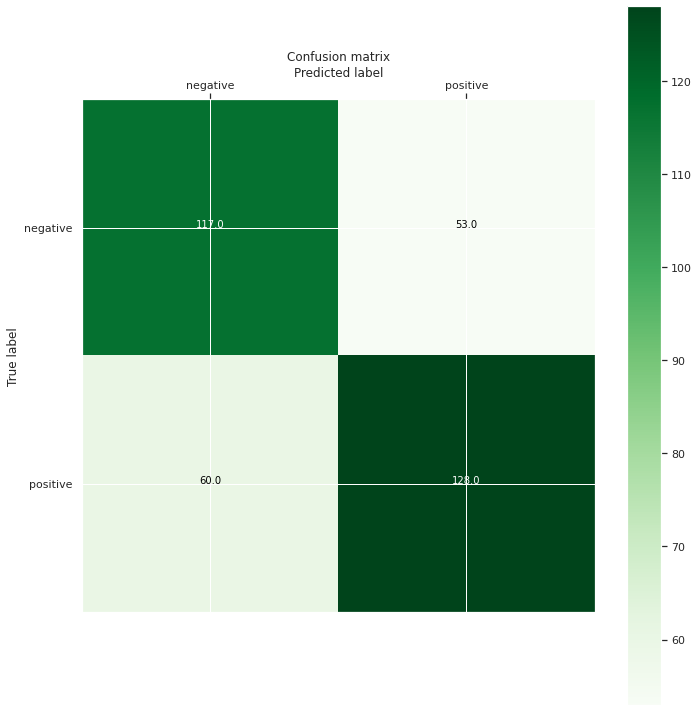

In [ ]:
plot_confusion_matrix(create_confusion_matrix( predictions , testData['polarity'].values , 2), ['negative' , 'positive'], normalize=False, title='Confusion matrix', cmap=plt.cm.Greens)
